## Для КТ по Torch Serving
https://ithub.bulgakov.app/lessons/62159#34417


## Подключение библиотек

In [ ]:
# Прочие библиотеки
import os 
import numpy as np

import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков

# Для загрузки изображений в xTest
from PIL import Image # импортируем модель Image для работы с изображениями
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями

## Загрузка изображений пользователя для отправки на сервер

In [ ]:
from google.colab import files # Импортируем Модуль files для загрузки файлов

# Целевые размеры
img_width  = 640 # Ширина картинки для подачи в нейронную сеть
img_height = 480 # Высота картинки для подачи в нейронную сеть
# Число классов для сегментации
num_classes = 2

uploaded_files = files.upload()

# Приведение всех изображений к нужному размеру + сохранение в список
x_test_images = []
x_test_images.append(image.load_img(list(uploaded_files.keys())[0], target_size=(img_height, img_width)))

Saving d2659acabd99_02.jpg to d2659acabd99_02.jpg


In [ ]:
# Данные загружены в формате PIL изображений
print(type(x_test_images[0]))

<class 'PIL.Image.Image'>


In [ ]:
# Перевод изображений в NumPy массивы
x_test = np.array([image.img_to_array(img) for img in x_test_images])

In [ ]:
print(type(x_test), x_test.shape)
print(x_test[0].shape)

<class 'numpy.ndarray'> (1, 480, 640, 3)
(480, 640, 3)


In [ ]:
# Каким будет содержимое x_test после .tolist()
# TODO: Данные во float, перевести в int?
# Вот таким: [[[ [251.0, 251.0, 251.0], [251.0, 251.0, 251.0], [251.0, 251.0, 251.0], [251.0, 251.0, 251.0], [251.0, 251.0, 251.0], ...], [[2
x_test = x_test.tolist()
print(type(x_test))
print(x_test) # Пример

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## TF Serving request НАСТРОЙКА МОЕГО СОЕДИНЕНИЯ с контейнером на сервере

In [ ]:
import requests 
import json 

In [ ]:
# Формируем пакет из данных для выполнение операции предсказания с помощью модели, размещенной с помощью TF Serving
pack = {
  "signature_name": "serving_default",
  "instances": x_test
} # tolist = Перевод всех NumPy массивов в списки для формата JSON
print(pack)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# Формируем данные для отправки на сервер
data = json.dumps(pack)
headers = {"content-type": "application/json"} # Заголовок требуется для корректрой обработки данных, представленных в формате json

print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))
print()

# Отправляем сформированные данные на сервер
# Указал свой ip и порт 8801 в соотв. с заданием
json_response = requests.post('http://94.198.217.236:8801/v1/models/cars_segmentation_model/versions/1:predict', data=data, headers=headers)
print("Код ответа:", json_response.status_code)
print()
predictions = json.loads(json_response.text)['predictions']

Data: {"signature_name": "serving_default", "instances": ... 0], [194.0, 188.0, 176.0], [194.0, 188.0, 176.0]]]]}

Код ответа: 200



In [ ]:
# Результат от модели это вероятности с которыми каждый пиксель относится к определённому классу.
# Эти вероятности нужно перегнать и в соответствии с ними отобразить результат сегментации изображения пользователя.
# Перевод predictions в NumPy массив
predictions = np.array(predictions)
predictions[:10]

array([[[[9.54134643e-01, 4.58653569e-02],
         [9.28889394e-01, 7.11106062e-02],
         [9.85230565e-01, 1.47693772e-02],
         ...,
         [9.96521533e-01, 3.47840064e-03],
         [9.99795437e-01, 2.04475902e-04],
         [9.95279670e-01, 4.72037401e-03]],

        [[9.69724536e-01, 3.02754231e-02],
         [9.55795169e-01, 4.42048000e-02],
         [9.71978307e-01, 2.80217063e-02],
         ...,
         [9.99834776e-01, 1.65301099e-04],
         [9.99998033e-01, 1.87335343e-06],
         [9.99966562e-01, 3.33815078e-05]],

        [[9.96170640e-01, 3.82931158e-03],
         [9.89631116e-01, 1.03688668e-02],
         [9.92386341e-01, 7.61366216e-03],
         ...,
         [9.99936759e-01, 6.31250223e-05],
         [9.99999225e-01, 7.04941897e-07],
         [9.99989000e-01, 1.09268312e-05]],

        ...,

        [[9.99999821e-01, 1.76743725e-07],
         [9.99996960e-01, 2.97733845e-06],
         [9.99999940e-01, 4.27414000e-08],
         ...,
         [9.99997914e

## Отображение результата сегментации от сервера

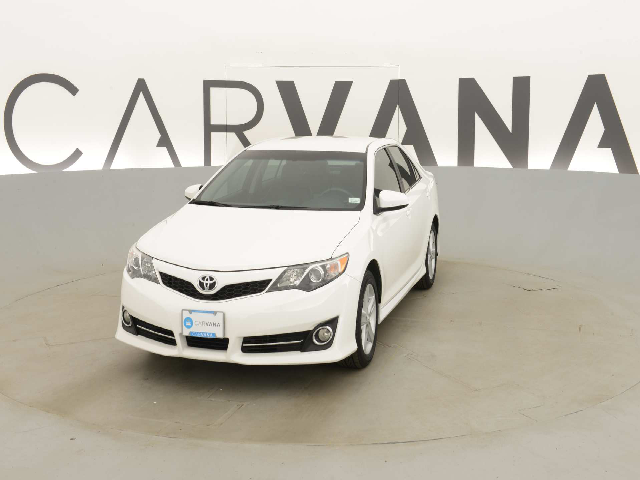

In [ ]:
# Изображение что подавалось на сервер
car = x_test_images[0]
car_rgba = car.convert("RGBA") # Изображение в RGB, а для того, чтобы сделать все пиксели, кроме авто прозрачными, нужен RGBA
car.show()

In [ ]:
# Функция обратного преобразования OHE в изображение маску
def index2color(index2):
  index = np.argmax(index2)
  color = []
  if index == 0:
    color = [0, 0, 0]  # фон
  else:
    color = [255, 0, 0]  # самолет
  return color


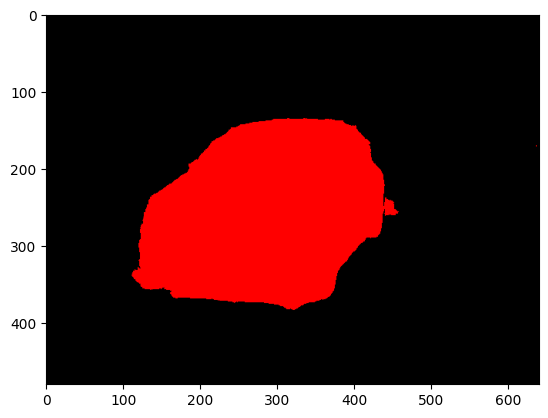

In [ ]:
predict = predictions.reshape(-1, num_classes) # Решейп предикта

pr1 = [] # Пустой лист под сегментированную картинку из predicta

for k in range(len(predict)): # Проходим по всем уровням (количесвто классов)
    pr1.append(index2color(predict[k])) # Переводим индекс в писксель

pr1 = np.array(pr1) # Преобразуем в numpy
pr1 = pr1.reshape(img_height, img_width, 3) # Решейпим к размеру изображения
img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
img = img.convert("RGBA")
plt.imshow(img)

In [ ]:
# Переводим маску в numpy-массив
car_seg_arr = image.img_to_array(img)
print(car_seg_arr.shape)
print(type(car_seg_arr))

(480, 640, 4)
<class 'numpy.ndarray'>


In [ ]:
# Вырезаю автомобиль по маске

# 1) Перевести изображения в numpy массивы

# Перевожу изображения в массивы
car_data = car_rgba.getdata()              # Получаем данные картинки
car_arr = np.array(car_data)          # Преобразуем в np массив
car_arr = car_arr.reshape(img_height, img_width, 4)         # Возращаем нужную конфигурацию np массиву
print("car_arr", car_arr.shape)

seg_car_data = img.getdata()      # Получаем данные картинки
seg_car_arr = np.array(seg_car_data)  # Преобразуем в np массив
seg_car_arr = seg_car_arr.reshape(img_height, img_width, 4) # Возращаем нужную конфигурацию np массиву
print("seg_car_arr", seg_car_arr.shape)

car_arr (480, 640, 4)
seg_car_arr (480, 640, 4)


In [ ]:
# 2) Итерация по массиву изображения сегментированной машины.
# Необходимо брать цвет каждого пикселя. 
# Если он не красный - установить значение этого же пикселя у изображения машины на прозрачный.

for y in range(car_rgba.size[1]): # по строкам высоты
    for x in range(car_rgba.size[0]): # по столбцам строки
        if seg_car_arr[y][x][0] <= 10: # красного цветам мало [y][x][r,g,b,a]
            car_arr[y][x] = [0,0,0,0] # Делаю прозрачным

In [ ]:
# 3) Возращаю изображение из массива в картинки
car_arr = car_arr.astype('uint8')
car_res = Image.fromarray(car_arr)

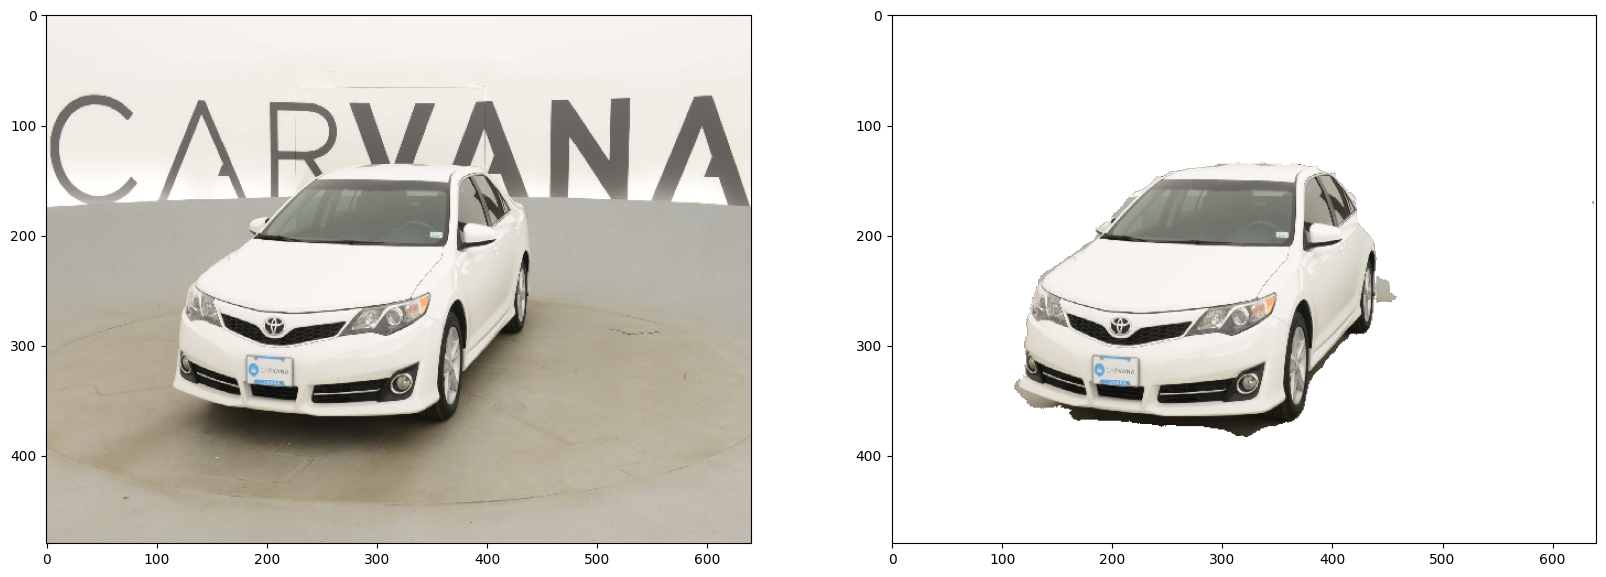

In [ ]:
# Изображения после вырезки
fig, axs = plt.subplots(1, 2, figsize=(20, 10)) # Создаем полотно нужной размерности

axs[0].imshow(car)     # Отображаем исходную машину
axs[1].imshow(car_res)            # Отображаем вырезанную машину

plt.show() # Показываем изображения